In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from config import *
from datasets import FashionDataset, FashionPipeline
from utils import *
from model import *
import torch
import matplotlib.pyplot as plts
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader,ConcatDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ERROR:root:/mnt/d/Playground/Research/Synthesising Virtual Fashion Try-On with Neural Radiance Fields/Results does not exist.
ERROR:root:/mnt/d/Playground/Research/Synthesising Virtual Fashion Try-On with Neural Radiance Fields/Dataset does not exist.


config:  /mnt/d/Playground/Research/Synthesising Virtual Fashion Try-On with Neural Radiance Fields/FashionNeRF


/home/molefe/anaconda3/envs/FashionNeRF/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


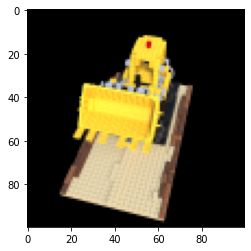

In [3]:
file_name = "tiny_nerf_data.npz"
url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"
if not os.path.exists(file_name):
    data = keras.utils.get_file(fname=file_name, origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [4]:
poses.shape

(106, 4, 4)

In [6]:
focal

array(138.8888789)

In [5]:
class InputPipeline(Dataset):
    def __init__(self,images,poses,width,height,focal_length,nC=8,near=2.0,far=6.0,rand=True):
        self.poses = poses
        self.images = images
        self.width = width
        self.height = height
        self.focal_length = focal_length
        self.nC = nC
        self.near = near
        self.far = far
        self.rand = rand
    
    def __len__(self):
        return len(self.poses)
    
    def __getitem__(self,index):
        pose = self.poses[index]
        image = self.images[index]
        rays_flat,t_vals = map_fn(pose,self.focal_length,self.width,self.height,self.near,self.far,self.nC,rand=self.rand)
        return image,rays_flat,t_vals

In [6]:
split_index = 85
W = width = image_width = 100
H = height = image_height = 100 

In [7]:
training_pipeline = InputPipeline(images[:split_index],poses[:split_index],width,height,focal,nC=NUM_SAMPLES,near=near,far=far,rand=True)
training_dataloader = DataLoader(training_pipeline, batch_size=5,shuffle=True)

In [8]:
image,rays_flat,t_vals = iter(training_dataloader).next()
image.shape,rays_flat.shape,t_vals.shape

(torch.Size([5, 100, 100, 3]),
 torch.Size([5, 120000, 99]),
 torch.Size([5, 100, 100, 12]))

In [18]:
len(np.unique(image[0]))

7449

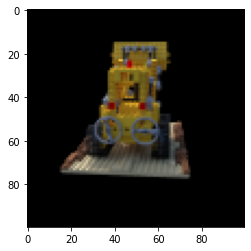

In [12]:
plt.imshow(image[0].cpu().detach().numpy())

In [13]:
image.shape

torch.Size([5, 100, 100, 3])

In [9]:
net = Net(num_layers,num_pos,encode_dims).to(device)

In [10]:
#  tensorboard --logdir=tensorboard 
step = 0
LEARNING_RATE = 2e-4
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
net.train()
do_train = True

In [11]:
torch.cuda.empty_cache()

In [12]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  235046 KB |  235046 KB |  235046 KB |       0 B  |\n|       from large pool |  234375 KB |  234375 KB |  234375 KB |       0 B  |\n|       from small pool |     671 KB |     671 KB |     671 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  235046 KB |  235046 KB |  235046 KB |       0 B  |\n|       from large pool |  234375 KB |  234375 KB |

In [13]:
if do_train:
    for epoch in range(EPOCHS):
        running_loss = 0
        for batch_idx,data in enumerate(training_dataloader):
            image,rays_flat,t_vals = data
            rays_flat = rays_flat.to(device,torch.float32)
            t_vals = t_vals.to(device,torch.float32)
            image = image.to(device)
            rgb,_ = render_rgb_depth(net,rays_flat,t_vals,device,rand=rand,train=True)
            optimizer.zero_grad()
            loss = criterion(image.permute(0,3,1,2),rgb.permute(0,3,1,2))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx%20 == 0:
                print(f"[{epoch+1},{batch_idx+1:5d}] loss: {running_loss/85:.5f}")
                with torch.no_grad():
                    rgb, _ = render_rgb_depth(net,rays_flat,t_vals,device,rand=rand,train=True)
                    img_grid_real = torchvision.utils.make_grid(image.permute(0,3,1,2)[:4],normalize=True)
                    img_grid_rgb = torchvision.utils.make_grid(rgb.permute(0,3,1,2)[:4],normalize=True)
                    writer_real.add_image('Real',img_grid_real,global_step=step)
                    writer_nerf.add_image('Nerf',img_grid_rgb,global_step=step)
                step += 1
    checkpoint = {'state_dict':net.state_dict(),'optimizer':optimizer.state_dict()}    
    save_checkpoint(checkpoint)
    print("Finished traning")

[1,    1] loss: 0.00088
[2,    1] loss: 0.00074
[3,    1] loss: 0.00084
[4,    1] loss: 0.00095
[5,    1] loss: 0.00074
[6,    1] loss: 0.00063
[7,    1] loss: 0.00067
[8,    1] loss: 0.00051
[9,    1] loss: 0.00041



KeyboardInterrupt

